In [1]:
#!/usr/bin/env python

import math
import sys

from ROOT import TH1, TH1F, TH2F, TFile, TCanvas, TPad, TLegend, TLatex, TColor, TMath, TVectorD, TGraph, TUnfold, Double, TSpline, TSpline3, TUnfoldDensity, TUnfoldSys, TAttLine, TStyle

from array import array
import string

from plotting import *

class Background :
    def __init__(self, name, hist, norm, err):
        self.name = name
        self.hist = hist
        self.norm = norm
        self.err  = err

class Systematic :
    def __init__(self, name, response):
        self.name = name
        self.response = response

Welcome to JupyROOT 6.10/09


In [2]:
# -------------------------------------------------------------------------------------
# Get nominal response matrix
# -------------------------------------------------------------------------------------
unfolding_input = TFile("../data/unfolding_input.root")
response = unfolding_input.Get("response")

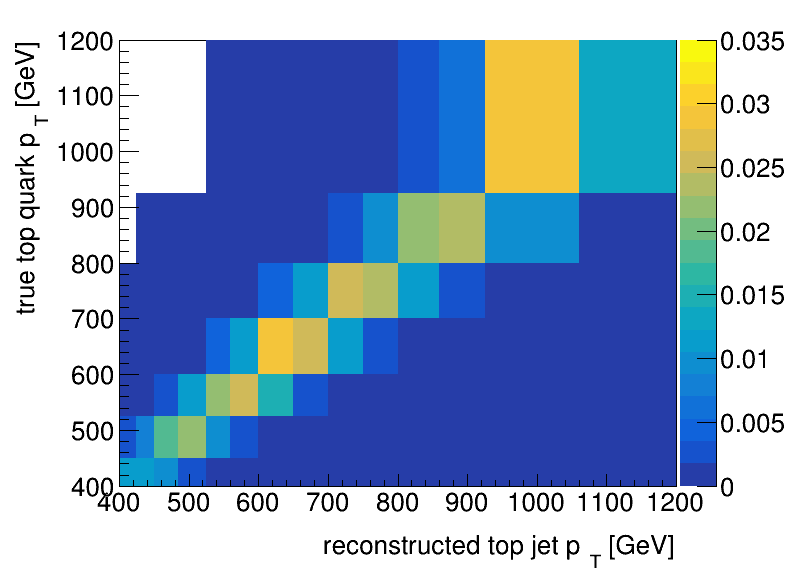

In [3]:
# -------------------------------------------------------------------------------------
# Draw response matrix
# -------------------------------------------------------------------------------------

response_norm = response.Clone("response_norm")

c1 = TCanvas("c1", "", 800, 600)
c1.SetTopMargin(0.07)
c1.SetRightMargin(0.15)
c1.SetBottomMargin(0.15)
c1.SetLeftMargin(0.15)

for ibiny in xrange(1,response_norm.GetNbinsY()+1):
    tmp = response_norm.Integral(0,response_norm.GetNbinsX()+1,ibiny,ibiny)
    for ibinx in xrange(1,response_norm.GetNbinsX()+1):
        response_norm.SetBinContent(ibinx,ibiny,response_norm.GetBinContent(ibinx,ibiny)/tmp)    

response_norm.SetTitle(";reconstructed top jet p_{T} [GeV];true top quark p_{T} [GeV]")
response_norm.GetZaxis().SetRangeUser(0.0,0.035)
response_norm.Draw("colz")

c1.Draw()

In [4]:
# -------------------------------------------------------------------------------------
# Get data distribution
# -------------------------------------------------------------------------------------

measurement = unfolding_input.Get("measured")

In [5]:
# -------------------------------------------------------------------------------------
# Get true distribution
# -------------------------------------------------------------------------------------

expectation = unfolding_input.Get("expected")

In [6]:
# -------------------------------------------------------------------------------------
# Get backgrounds distribution
# -------------------------------------------------------------------------------------
backgrounds = {}
backgrounds["TT_nonsemi"] = Background("TT_nonsemi",unfolding_input.Get("tt_nonsemi"),0.80,0.08)
backgrounds["SingleTop"]  = Background("SingleTop" ,unfolding_input.Get("SingleTop") ,1.32,0.57)
backgrounds["WJetsL"]     = Background("WJetsL"    ,unfolding_input.Get("WJetsL")    ,0.78,0.18)
backgrounds["WJetsHF"]    = Background("WJetsHF"   ,unfolding_input.Get("WJetsHF")   ,1.05,0.30)
backgrounds["ZJets"]      = Background("ZJets"     ,unfolding_input.Get("ZJets")     ,0.67,0.24)
backgrounds["Diboson"]    = Background("Diboson"   ,unfolding_input.Get("Diboson")   ,0.99,0.31)
backgrounds["muQCD"]      = Background("muQCD"     ,unfolding_input.Get("muQCD")     ,0.71,0.75)
backgrounds["elQCD"]      = Background("elQCD"     ,unfolding_input.Get("elQCD")     ,0.90,0.65)

In [7]:
# -------------------------------------------------------------------------------------
# Get systematic variations for response matrix
# -------------------------------------------------------------------------------------

systematics = {}
for name in ["JEC","JER","BTag","TopTag","lep","pu","PDF","Q2","ISR","FSR","Tune","Hdamp"]:
    systematics[name] = Systematic(name,unfolding_input.Get("response_"+name))

In [8]:
# -------------------------------
# Convert for TUnfold
# -------------------------------

# Get 'ttbar' part of thisMeas
for name, background in backgrounds.iteritems():
    measurement.Add(background.hist,-1.0*background.norm)

# Scale down 'ttbar' part of measurement to account for fake fraction, as given by response matrix
for ii in xrange(1,response.GetNbinsX()+1):
    if response.Integral(ii,ii,0,response.GetNbinsY()+1) > 0.0 :
        fakefraction = response.GetBinContent(ii,0) / response.Integral(ii,ii,0,response.GetNbinsY()+1)
        measurement.SetBinContent(ii,measurement.GetBinContent(ii)*(1.0-fakefraction))
        measurement.SetBinError(ii,measurement.GetBinError(ii)*(1.0-fakefraction))
        response.SetBinContent(ii,0,0)
        response.SetBinError(ii,0,0)

# Now add back background contribution to thisMeas
for name, background in backgrounds.iteritems():
    measurement.Add(background.hist, background.norm)

In [9]:
# -------------------------------------------------------------------------------------
# Do unfolding
# -------------------------------------------------------------------------------------

%jsroot off

unfold = TUnfoldDensity(response,TUnfold.kHistMapOutputVert, TUnfold.kRegModeCurvature, TUnfold.kEConstraintArea, TUnfoldDensity.kDensityModeBinWidth)
unfold.SetInput(measurement)

# Add systematic uncertainties
for name, systematic in systematics.iteritems():
    unfold.AddSysError(systematic.response,name,TUnfold.kHistMapOutputVert,TUnfoldDensity.kSysErrModeMatrix)
            
# Subtract backgrounds with appropriate scale / uncertainty
for name, background in backgrounds.iteritems():
    unfold.SubtractBackground(background.hist,background.name,background.norm,background.err)
    
# Do unfolding using LCurve to determine regularization strength
#cc = TCanvas("cc", "cc", 700, 700)
#cc.cd()
#logTauX = TSpline3()
#logTauY = TSpline3()
#lCurve = TGraph()
#bestLCurve = TGraph(1)
#iBest = unfold.ScanLcurve(30,0.,0.,lCurve,logTauX,logTauY)
#Tau = Double(0)
#x = Double(0)
#y = Double(0)
#logTauX.GetKnot(iBest,Tau,x)
#logTauY.GetKnot(iBest,Tau,y)
#bestLCurve.SetPoint(1,x,y)
#bestLCurve.SetMarkerColor(2)
#lCurve.GetXaxis().SetTitle("log L_{1}")
#lCurve.GetYaxis().SetTitle("log L_{2} / #tau^{2}")
#lCurve.Draw()
#bestLCurve.Draw("*")
#tl2 = TLatex()
#tl2.SetNDC()
#tl2.SetTextFont(42)
#legend = "log(#tau) = %.3e" % Tau
#tl2.DrawLatex(0.55,0.8,legend)
#cc.SaveAs("lcurve_scan.pdf")

# Do unfolding using ScanTau to determine regularization strength
#cc = TCanvas("cc", "cc", 700, 700)
#cc.cd()
#bestTau = TGraph(1)
#scanResult = TSpline3()
#iBest = unfold.ScanTau(100,0.0001,0.1,scanResult,TUnfoldDensity.kEScanTauRhoAvgSys)
#Tau = Double(0)
#rho = Double(0)
#scanResult.GetKnot(iBest,Tau,rho)
#bestTau.SetPoint(1,Tau,rho)
#bestTau.SetMarkerColor(2)
#scanResult.Draw("P")
#bestTau.Draw("*")
#tl2 = TLatex()
#tl2.SetNDC()
#tl2.SetTextFont(42)
#legend = "log(#tau) = %.3e" % Tau
#tl2.DrawLatex(0.55,0.8,legend)
#cc.Draw()

# Do non-regularized unfolding
unfold.DoUnfold(0)

0.6948017933549879

Info in <TUnfold::SetConstraint>: fConstraint=1
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 14 input bins and 7 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (yaxis:p_{T}(generated top) [GeV][ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #8 (yaxis:p_{T}(generated top) [GeV][ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing yaxis regMode=3 densityMode=1 axisSteering=*[UOB]


In [10]:
# unfolded distribution (histogram)
result = unfold.GetOutput("result")
result.Sumw2()

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [11]:
# -------------------------------------------------------------------------------------
# Get covariance matrices for each uncertainty source
# -------------------------------------------------------------------------------------

# Input statistical uncertainty
mCovInput = unfold.GetEmatrixInput("mCovInput")

# Response matrix statistical uncertainty
mCovMatrix = unfold.GetEmatrixSysUncorr("mCovMatrix")
    
# Systematic uncertainties (from different response matrices)
mCovSys = mCovInput.Clone("mCovSys")
mCovSys.Reset()
for name in systematics:
    hUncSys = unfold.GetDeltaSysSource(name,"hUncSys_"+name)
    for ibin in xrange(1,mCovSys.GetNbinsX()+1):
        mCovSys.SetBinContent(ibin,ibin,mCovSys.GetBinContent(ibin,ibin)+pow(hUncSys.GetBinContent(ibin),2))

# Background uncertainties (statistical and normalization)
mCovBkg = mCovInput.Clone("mCovBkg")
mCovBkg.Reset()
for name, background in backgrounds.iteritems():
    mCovBkgStat = unfold.GetEmatrixSysBackgroundUncorr(background.name,"mCovBkgStat_"+background.name)
    mCovBkg.Add(mCovBkgStat)
    hUncBkgScale = unfold.GetDeltaSysBackgroundScale(background.name,"hUncBkgScale_"+background.name)
    for ibin in xrange(1,mCovBkg.GetNbinsX()+1):
        mCovBkg.SetBinContent(ibin,ibin,mCovBkg.GetBinContent(ibin,ibin)+pow(hUncBkgScale.GetBinContent(ibin),2))

# Total covariance matrix
mCovTot = unfold.GetEmatrixTotal("mCovTot")

In [12]:
# -------------------------------------------------------------------------------------
# Create relative uncertainty hists from covariance matrices
# -------------------------------------------------------------------------------------

template = result.Clone()
template.Reset()

inputUnc  = template.Clone("inputUnc")
matrixUnc = template.Clone("matrixUnc")
sysUnc    = template.Clone("sysUnc")
bkgUnc    = template.Clone("bkgUnc")
totUnc    = template.Clone("totUnc")

for ibin in xrange(1,result.GetNbinsX()+1):
    inputUnc.SetBinContent(ibin,math.sqrt(mCovInput.GetBinContent(ibin,ibin))/result.GetBinContent(ibin))
    matrixUnc.SetBinContent(ibin,math.sqrt(mCovMatrix.GetBinContent(ibin,ibin))/result.GetBinContent(ibin))
    sysUnc.SetBinContent(ibin,math.sqrt(mCovSys.GetBinContent(ibin,ibin))/result.GetBinContent(ibin))
    bkgUnc.SetBinContent(ibin,math.sqrt(mCovBkg.GetBinContent(ibin,ibin))/result.GetBinContent(ibin))
    totUnc.SetBinContent(ibin,math.sqrt(mCovTot.GetBinContent(ibin,ibin))/result.GetBinContent(ibin))

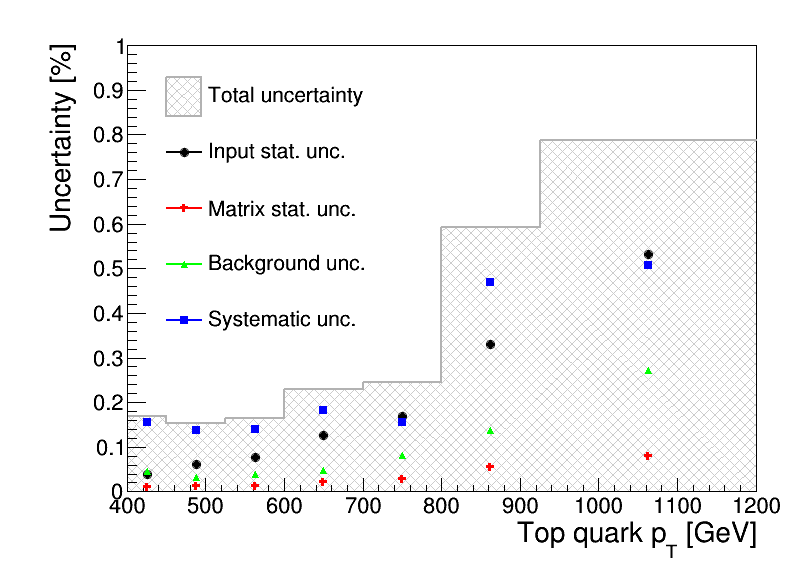

In [13]:
# -------------------------------------------------------------------------------------
# Plot error breakdown
# -------------------------------------------------------------------------------------

c2 = TCanvas("c2", "", 800, 600)
c2.SetTopMargin(0.08)
c2.SetRightMargin(0.05)
c2.SetBottomMargin(0.14)
c2.SetLeftMargin(0.16)

totUnc.GetXaxis().SetTitle("Top quark p_{T} [GeV]")
totUnc.GetYaxis().SetTitle("Uncertainty [%]")
totUnc.GetYaxis().SetRangeUser(0.0,1.0)
    
c2.cd()
    
totUnc.SetFillColor(17)
totUnc.SetFillStyle(3344)
totUnc.SetLineColor(16)
totUnc.SetLineWidth(2)

inputUnc.SetLineColor(1)
inputUnc.SetLineWidth(2)
inputUnc.SetMarkerColor(1)
inputUnc.SetMarkerStyle(20)

matrixUnc.SetLineColor(2)
matrixUnc.SetLineWidth(2)
matrixUnc.SetMarkerColor(2)
matrixUnc.SetMarkerStyle(34)

bkgUnc.SetLineColor(3)
bkgUnc.SetLineWidth(2)
bkgUnc.SetMarkerColor(3)
bkgUnc.SetMarkerStyle(22)

sysUnc.SetLineColor(4)
sysUnc.SetLineWidth(2)
sysUnc.SetMarkerColor(4)
sysUnc.SetMarkerStyle(21)

leg2 = TLegend(0.2,0.39,0.45,0.88)
leg2.AddEntry(totUnc,   "Total uncertainty","f")
leg2.AddEntry(inputUnc, "Input stat. unc.","lp")
leg2.AddEntry(matrixUnc,"Matrix stat. unc.","lp")
leg2.AddEntry(bkgUnc,   "Background unc.","lp")
leg2.AddEntry(sysUnc,   "Systematic unc.","lp")
        
leg2.SetFillStyle(0);
leg2.SetBorderSize(0);
leg2.SetTextSize(0.04);
leg2.SetTextFont(42);

totUnc.Draw("hist")
inputUnc.Draw("ep,same")
matrixUnc.Draw("ep,same")
bkgUnc.Draw("ep,same")
sysUnc.Draw("ep,same")

leg2.Draw(); 

c2.Draw()

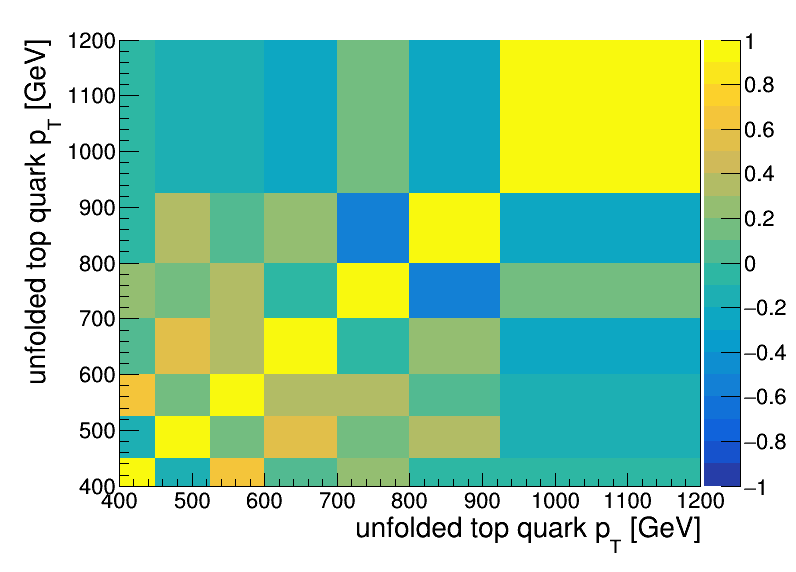

In [14]:
# -------------------------------------------------------------------------------------
# Plot covariance matrix
# -------------------------------------------------------------------------------------

c3 = TCanvas("c3", "", 800, 600)
c3.SetTopMargin(0.07)
c3.SetRightMargin(0.12)
c3.SetBottomMargin(0.15)
c3.SetLeftMargin(0.15)

# Normalize covariance matrix
diagonals = []
for ibin in xrange(1,mCovTot.GetNbinsX()+1):
    tmp = math.sqrt(mCovTot.GetBinContent(ibin,ibin)) if (math.sqrt(mCovTot.GetBinContent(ibin,ibin)) is not 0) else 1.0
    diagonals.append(tmp)
for ibinx in xrange(1,mCovTot.GetNbinsX()+1):
    for ibiny in xrange(1,mCovTot.GetNbinsY()+1):
        tmp = mCovTot.GetBinContent(ibinx,ibiny) / diagonals[ibinx-1] / diagonals[ibiny-1]
        mCovTot.SetBinContent(ibinx,ibiny,tmp)

mCovTot.GetZaxis().SetRangeUser(-1.0,1.0)
mCovTot.SetTitle(";unfolded top quark p_{T} [GeV];unfolded top quark p_{T} [GeV]")

mCovTot.Draw("colz")

c3.Draw()

In [15]:
# -------------------------------------------------------------------------------------
# Translate to cross section (not events) in bins of pt N/L/BR)
# -------------------------------------------------------------------------------------

BR = 0.172 + 0.173 # Branching ratio for semileptonic final state
lum = 35867.0      # 2016 luminosity

expectation.Scale(1.0/(lum*BR)) 
measurement.Scale(1.0/(lum*BR))
result.Scale(1.0/(lum*BR))

In [16]:
# -------------------------------------------------------------------------------------
# Adjust for bin width
# -------------------------------------------------------------------------------------

for ibin in range(1, result.GetNbinsX()+1 ) :
    width = expectation.GetBinWidth(ibin)
    expectation.SetBinContent(ibin, expectation.GetBinContent(ibin) / width )
    expectation.SetBinError(ibin, expectation.GetBinError(ibin) / width )
    result.SetBinContent(ibin, result.GetBinContent(ibin) / width )
    result.SetBinError(ibin, result.GetBinError(ibin) / width )
    
for ibin in range(1, measurement.GetNbinsX()+1) :  
    width = measurement.GetBinWidth(ibin)
    measurement.SetBinContent(ibin,  measurement.GetBinContent(ibin) / width )
    measurement.SetBinError(ibin,  measurement.GetBinError(ibin) / width )

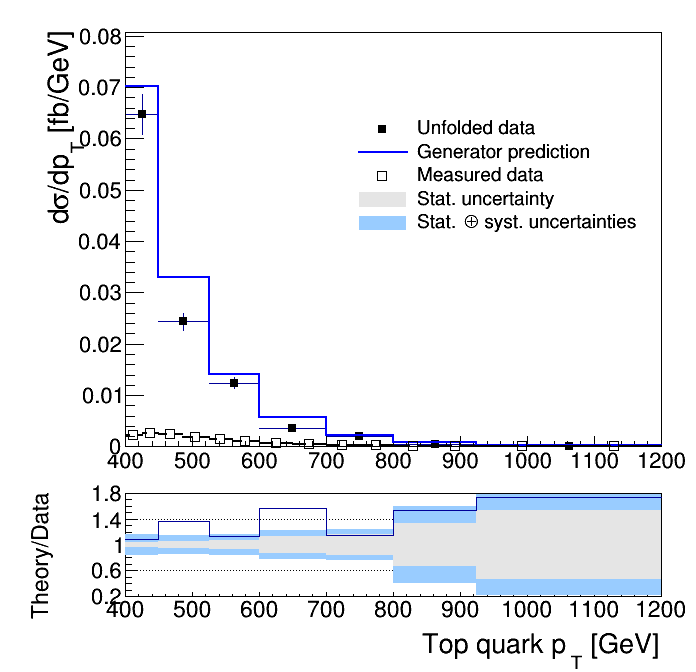

In [17]:
     
# -------------------------------------------------------------------------------------
# draw parton-level unfolding
# -------------------------------------------------------------------------------------
    
## ratio of unfolded data to generator-level
ratio = expectation.Clone()
ratio.SetName("ratio")
ratio.SetTitle(";Top quark p_{T} [GeV];Theory/Data")
ratio.Divide(result)
    
# Convert total, statistical uncertainty into error bands
for ibin in xrange(1,expectation.GetNbinsX()+1):
    totUnc.SetBinError(ibin,totUnc.GetBinContent(ibin))
    totUnc.SetBinContent(ibin,1.0)
    inputUnc.SetBinError(ibin,inputUnc.GetBinContent(ibin))
    inputUnc.SetBinContent(ibin,1.0)
        
totUnc.SetMarkerSize(0)
totUnc.SetLineColor(0)
totUnc.SetFillColor(860-9)
totUnc.SetFillStyle(1001)
    
inputUnc.SetMarkerSize(0)
inputUnc.SetLineColor(0)
inputUnc.SetFillColor(18)
inputUnc.SetFillStyle(1001)
    
# Plot
c4 = TCanvas("c4", "", 700, 700)
pad1 =  TPad("pad1","pad1",0,0.3,1,1)
pad1.SetBottomMargin(0.05)
pad1.Draw()
pad1.cd()
    
result.SetMarkerStyle(21)
measurement.SetMarkerStyle(25)
expectation.SetLineColor(4)
expectation.GetYaxis().SetTitleSize(25)
expectation.GetXaxis().SetLabelSize(0)

result.SetTitle(";;d#sigma/dp_{T} [fb/GeV]")
result.GetYaxis().SetTitleOffset(1.2)
result.SetMinimum(0.0)
result.SetAxisRange(0,max(expectation.GetMaximum(),result.GetMaximum())*1.15,"Y")
result.Draw()
expectation.Draw('hist same')
measurement.Draw('same')
    
leg4 = TLegend(0.5, 0.5, 0.9, 0.75)
leg4.SetFillStyle(0)
leg4.SetTextFont(42)
leg4.SetTextSize(0.045)
leg4.SetBorderSize(0)
    
leg4.AddEntry( result, 'Unfolded data', 'p')
leg4.AddEntry( expectation, 'Generator prediction', 'l')
leg4.AddEntry( measurement, 'Measured data', 'p')
leg4.AddEntry( inputUnc, 'Stat. uncertainty','f');
leg4.AddEntry( totUnc, 'Stat. #oplus syst. uncertainties','f');
leg4.Draw()
    
c4.cd()
pad2 =  TPad("pad2","pad2",0,0.0,1,0.28)
pad2.SetTopMargin(0.05)
pad2.SetBottomMargin(0.4)
pad2.Draw()
pad2.cd()
pad2.SetGridy()
ratio.SetMaximum(1.8)
ratio.SetMinimum(0.2)
ratio.UseCurrentStyle()
ratio.GetYaxis().SetTitleSize(25)
ratio.GetYaxis().SetTitleOffset(2.0)
ratio.GetXaxis().SetTitleOffset(4.0)
ratio.GetXaxis().SetLabelSize(25)
ratio.GetYaxis().SetNdivisions(4,4,0,False)
    
ratio.Draw("hist")
totUnc.Draw("same,e2")
inputUnc.Draw("same,e2")
ratio.Draw("same,hist")
    
c4.Update()
c4.Draw()